In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext line_profiler

In [2]:
from functools import partial

import time
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams['text.usetex'] = True
import plotly.express as px
import plotly.graph_objects as go

In [3]:
import jax
import jax.numpy as jnp

import diffrax
import equinox as eqx
import optax

from haiku import PRNGSequence

In [4]:
import exciting_environments as excenvs

import exciting_exciting_systems as eesys
from exciting_exciting_systems.models.model_utils import simulate_ahead, simulate_ahead_with_env
from exciting_exciting_systems.optimization import loss_function, optimize, soft_penalty
from exciting_exciting_systems.utils.density_estimation import update_kde_grid, update_kde_grid_multiple_observations
from exciting_exciting_systems.utils.metrics import JSDLoss
from exciting_exciting_systems.utils.signals import generate_constant_action, aprbs
from exciting_exciting_systems.evaluation.plotting_utils import (
    plot_sequence, append_predictions_to_sequence_plot, plot_sequence_and_prediction
)

---

In [5]:
# setup PRNG
key = jax.random.PRNGKey(seed=21)

data_key, model_key, key = jax.random.split(key, 3)
data_rng = PRNGSequence(data_key)

In [6]:
batch_size = 20
tau = 1e-2

env = excenvs.make(
    env_id='Pendulum-v0',
    batch_size=batch_size,
    tau=tau
)

### Test simulation:

- starting from the intial state/obs ($\mathbf{x}_0$ / $\mathbf{y}_0$)
- apply $N = 999$ actions $\mathbf{u}_0 \dots \mathbf{u}_N$ (**here**: random APRBS actions)
- which results in the state trajectory $\mathbf{x}_0 ... \mathbf{x}_N+1$ with $N+1 = 1000$ elements

In [7]:
obs, state = env.reset()
obs = obs.astype(jnp.float32)
state = state.astype(jnp.float32)
n_steps = 999

actions = aprbs(n_steps, batch_size, 200, 500, next(data_rng))

actions.shape: (20, 999, 1)
observations.shape: (20, 1000, 2)
 
 One of the trajectories:


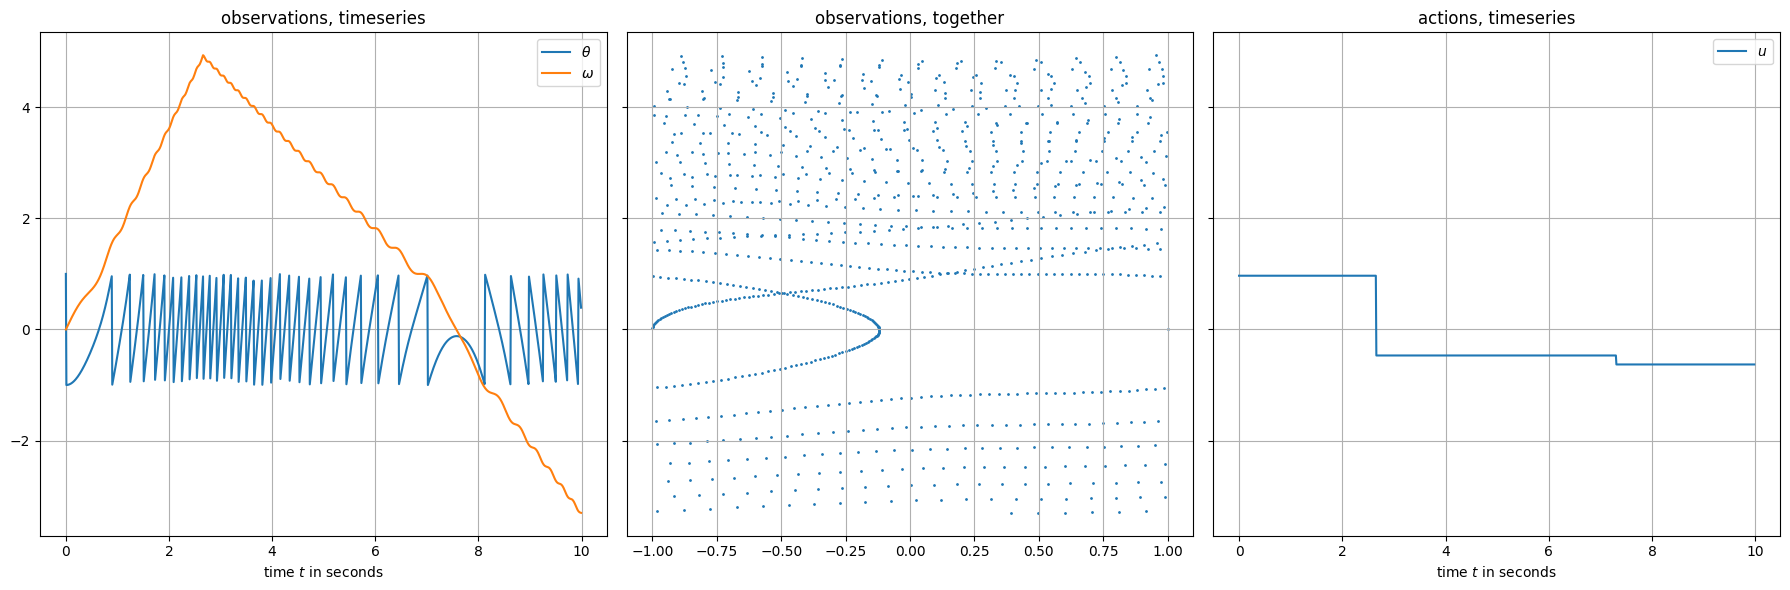

In [8]:
observations = jax.vmap(simulate_ahead_with_env, in_axes=(None, 0, 0, 0, 0, 0, 0))(
    env,
    obs,
    state,
    actions,
    env.env_state_normalizer,
    env.action_normalizer,
    env.static_params
)

print("actions.shape:", actions.shape)
print("observations.shape:", observations.shape)

print(" \n One of the trajectories:")
fig, axs = plot_sequence(
    observations=observations[0, ...],
    actions=actions[0, ...],
    tau=tau,
    obs_labels=[r"$\theta$", r"$\omega$"],
    action_labels=[r"$u$"],
);
plt.show()

## Build an algorithm that simultaneously learns the model and optimizes its trajectory: